# Pretending to be a Rates RV Portfolio Manager:
## An Introduction to Swaps Relative Value with Curvy-CUSIPS:

In [1]:
import sys
sys.path.append("../")

In [2]:
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.USTs import USTs
from CurvyCUSIPs.utils.pca_utils import calc_pca_loadings_matrix
from CurvyCUSIPs.utils.regression_utils import (
        run_basic_linear_regression_df, 
        run_multiple_linear_regression_df, 
        plot_residuals_timeseries,
        modified_partial_regression_fly_plot
)

from datetime import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay 
from pandas.tseries.holiday import USFederalHolidayCalendar

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
        'figure.figsize': (15, 9),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

## Setting up Curvy-CUSIPs' data fetching infra:

In [3]:
curve_data_fetcher = CurveDataFetcher(fred_api_key='200b7ef48c17a62796b10ce55c6eb9f8')

In [ ]:
import os

# Get absolute path from notebook location
notebook_dir = os.path.dirname(os.path.abspath(''))
db_path = os.path.join(notebook_dir, "db", "nyclose_sofr_ois")
print(f"Looking for database at: {db_path}")
print(f"Path exists: {os.path.exists(db_path)}")
print(f"Path exists with .dat extension: {os.path.exists(db_path + '.dat')}")

# List contents of the db directory
db_dir = os.path.join(notebook_dir, "db")
print("\nContents of db directory:")
if os.path.exists(db_dir):
    print(os.listdir(db_dir))
else:
    print("db directory not found!")

Looking for database at: /home/peter/coding/swaps/Curvy-CUSIPs/db/nyclose_sofr_ois
Path exists: False
Path exists with .dat extension: True

Contents of db directory:
['ust_mid_ct_yields.bak', 'ust_cusip_timeseries.dat', 'ust_cusip_timeseries.dir', 'ust_mid_ct_yields.dat', 'ust_bid_ct_yields.dat', 'ust_cusip_set.bak', 's490_swaption_atm_vol.bak', 'ust_eod_ct_yields.bak', 'ust_cusip_set.dir', 'ust_bid_ct_yields.dir', 'ust_offer_ct_yields.dir', 'ust_offer_ct_yields.bak', 'nyclose_sofr_ois.bak', 'ust_eod_ct_yields.dir', 's490_swaption_atm_vol.dir', 's490_swaption_vol_cube.dat', 'dsb_upis', 's490_swaption_atm_vol.dat', 'nyclose_sofr_ois.dir', 'ust_bid_ct_yields.bak', 'ust_mid_ct_yields.dir', 'ust_offer_ct_yields.dat', 's490_swaption_vol_cube.dir', 'ust_cusip_set.dat', 'xlsx', 'ust_cusip_timeseries.bak', 'ust_eod_ct_yields.dat', 'nyclose_sofr_ois.dat', 's490_swaption_vol_cube.bak']


In [ ]:
import os
notebook_dir = os.path.dirname(os.path.abspath(''))
db_path = os.path.join(notebook_dir, "db", "nyclose_sofr_ois")
print(f"Using database path: {db_path}")

Using database path: /home/peter/coding/swaps/Curvy-CUSIPs/db/nyclose_sofr_ois


In [6]:
sofr_ois = S490Swaps(s490_curve_db_path=db_path, curve_data_fetcher=curve_data_fetcher)

In [7]:

usts = USTs(
    cusip_set_db_path=r"../db/ust_cusip_set",
    cusip_timeseries_db_path=r"../db/ust_cusip_timeseries",
    ct_eod_db_path=r"../db/ust_eod_ct_yields",
    curve_data_fetcher=curve_data_fetcher,
)

In [8]:
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 28)
bdates = pd.date_range(start=start_date, end=end_date, freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))

In [9]:
fwd_tenors = ["1M", "3M", "6M", "9M", "12M", "18M", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y", "12Y", "15Y", "20Y"]
fwd_grid_dict, ql_curves = sofr_ois.s490_nyclose_fwd_curve_matrices(
    start_date=start_date,
    end_date=end_date,
    ql_piecewise_method="logLinearDiscount",
    fwd_tenors=fwd_tenors,
)

Building Implied Fwd Curves...:   0%|          | 0/269 [00:00<?, ?it/s]

Building Implied Fwd Curves...: 100%|██████████| 269/269 [00:01<00:00, 165.29it/s]


## PCA as a screener:

- Use PCA residuals as a rich/cheap signal 
- Many degrees of freedom to choose how you run PCA:
    - PCA on the spot and forward curves individually vs the entire grid
    - Timeframe selection and strategy: to roll or not to roll
    - Tenors selection
    - CurvyCUSIPs' Screener is based on the Standard Chartered Swaps RV Tool: returns a z-score table of PCA residuals
    - In this example:
        - ~1 year timeframe with a 3m (~60 day) rolling window
        - will run PCA on individual fwd strips
        - will run PCA on levels
        - will remove short end of the swap curve given its sensitivity to the Fed


- References:
    - [Standard Chartered Swaps RV Tool](https://github.com/yieldcurvemonkey/Curvy-CUSIPs/blob/main/research/PCA/Introducing_a_relative-value_tool_for_swaps_19_08_13_08_57.pdf)
    - [Credit Suisse PCA Unleashed](https://github.com/yieldcurvemonkey/Curvy-CUSIPs/blob/main/research/PCA/PCA%20Unleashed.%20Interest%20Rate%20Strategy.%20Spot%201y%201y1y%202y1y%203y1y%204y1y%205y1y%206y1y%207y1y%208y1y%209y1y%2010y2y%2012y3y%2015y5y%2020y5y%2025y5y%2030y10y%2040y10y.pdf)
    - [ASM Quant Macro PCA Part II](https://asmquantmacro.com/2015/06/29/principal-component-analysis-part-ii/)
    

In [10]:
pca_results = sofr_ois.pca_on_fwd_grids(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2025, 1, 16),
    fwd_grid_dict=fwd_grid_dict, 
    rm_swap_tenors=["1D", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "5M", "6M", "7M", "8M", "9M", "10M", "11M"],
    indy_fwd_strips=True,
    rolling_window=60,
    n_jobs_child=1,
    n_jobs_parent=6,
)

CLEANING UP ROLLING PCA RESULTS...: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


In [11]:
df = pca_results["rich_cheap_residual_zscore_timeseries_dict"][datetime(2025, 1, 17)]
df.style.background_gradient(cmap="RdYlGn", axis=0)

KeyError: datetime.datetime(2025, 1, 17, 0, 0)

In [30]:
df = pca_results["rich_cheap_residual_zscore_timeseries_dict"][datetime(2025, 1, 17)]- pca_results["rich_cheap_residual_zscore_timeseries_dict"][datetime(2025, 1, 16)]
df.style.background_gradient(cmap="RdYlGn", axis=0)

,Spot,1M Fwd,3M Fwd,6M Fwd,9M Fwd,12M Fwd,18M Fwd,2Y Fwd,3Y Fwd,4Y Fwd,5Y Fwd,6Y Fwd,7Y Fwd,8Y Fwd,9Y Fwd,10Y Fwd,12Y Fwd,15Y Fwd,20Y Fwd
Tenor,,,,,,,,,,,,,,,,,,,
12M,1.659574,-0.227054,-0.485951,1.147280,-1.411267,-0.322105,-1.670056,-1.429819,2.131403,-1.134219,-1.538806,-0.469795,-1.254344,0.898650,-0.638399,0.654852,-1.511227,-0.631400,1.036902
18M,-1.892735,1.204452,0.626970,-1.404722,-0.686439,-0.516050,0.142196,2.213409,-2.244124,0.217142,2.176128,-0.175570,1.947512,-0.901003,0.368941,0.770127,-1.560923,-1.610640,0.496404
2Y,-1.974689,-0.839426,-0.415486,-1.304436,0.697219,-0.083951,2.363433,1.997308,-2.347238,0.347324,2.130436,0.018102,1.880176,-0.970133,0.764647,0.826612,-1.584785,-2.058119,-0.212362
3Y,-1.038401,-0.154765,0.781883,1.097611,2.340038,2.069715,0.987091,-1.895747,0.945782,1.674441,-0.147148,1.760339,-0.507395,-0.615550,0.788081,-1.586239,-1.606883,-2.286524,-0.863399
4Y,0.289346,1.750911,1.710006,0.684125,0.222875,-1.402732,0.068049,0.661976,1.885869,0.633276,0.839213,-0.321082,-0.198620,-0.039269,0.243294,-1.341544,0.478678,-2.320760,-1.045338
5Y,2.331090,-1.236316,-0.832364,0.145514,0.555673,0.711910,1.422097,1.252986,0.762760,0.242900,-1.425288,-0.157758,0.178244,-0.214702,-0.510644,-1.280981,1.041005,-2.324277,-1.117104
6Y,2.108893,0.725060,0.722380,1.780418,0.862188,0.999000,0.698237,0.027152,1.593908,-1.296314,-1.364820,0.134752,-1.301328,-0.298290,-0.817079,-0.891335,1.121258,2.657675,-0.602256
7Y,1.538855,0.838514,0.506296,0.986960,-0.194076,-0.072492,0.407083,0.998243,-0.417807,-1.118205,-0.854832,-1.022831,-1.771004,-0.246977,-0.523095,-0.014570,1.147223,2.101505,0.189995
8Y,1.097726,0.245860,0.034597,0.754391,-0.263035,0.580104,-0.871587,-1.163108,-0.422466,-0.702198,-2.503281,-1.317162,-1.663022,0.336769,0.104755,0.931984,1.154472,1.970242,0.301221


In [12]:
df = pca_results["rich_cheap_residual_zscore_timeseries_dict"][datetime(2025, 1, 2)]
df.style.background_gradient(cmap="RdYlGn", axis=0)

,Spot,1M Fwd,3M Fwd,6M Fwd,9M Fwd,12M Fwd,18M Fwd,2Y Fwd,3Y Fwd,4Y Fwd,5Y Fwd,6Y Fwd,7Y Fwd,8Y Fwd,9Y Fwd,10Y Fwd,12Y Fwd,15Y Fwd,20Y Fwd
Tenor,,,,,,,,,,,,,,,,,,,
12M,-1.196271,-0.261628,0.017055,-0.651307,1.036946,0.535989,0.523097,0.325634,-2.478005,0.052820,-1.225349,2.458351,-0.079500,0.995414,-0.050562,-0.020522,-0.643137,-1.373732,-0.874426
18M,1.908867,-0.134953,-0.029016,0.809737,-0.093812,-0.773198,-0.804250,-2.118072,1.067077,2.002041,0.985540,-1.604623,-0.415141,-1.049524,-0.422664,0.149957,-0.624020,-1.809618,-1.841787
2Y,1.082526,0.696219,0.348548,0.221523,-1.163497,-0.653452,-1.909376,-1.528259,1.894881,1.988395,1.032253,-2.035475,-0.225497,-1.056623,-0.113329,0.234146,-0.612196,-1.871626,-2.645925
3Y,0.348583,-0.051120,-0.721408,-1.020220,-1.884601,-1.729292,0.287156,1.613992,1.183908,-0.284639,-2.010219,-0.803639,-0.146860,-0.995380,-0.045985,-0.207157,-0.600752,-1.748786,-1.771021
4Y,-0.603685,-1.174435,-0.911726,0.062945,0.615786,1.435816,2.198934,1.117456,0.838484,-3.171554,-1.031745,-0.969684,-0.320380,-0.581168,0.003085,-0.215644,-0.156673,-1.644685,-1.340564
5Y,-0.109003,1.254260,1.849889,2.086720,1.639063,1.240156,1.830382,0.773320,-2.344576,-1.612385,-1.188871,-0.837764,-0.375055,-0.225520,0.060697,-0.213461,0.093183,-1.577380,-1.159853
6Y,-0.170681,0.797540,1.239971,1.512230,1.718330,1.043642,-0.429694,-2.234565,-1.454212,-1.963618,-1.063728,-0.444330,0.482328,0.395743,0.081840,-0.189301,0.139072,1.447712,2.335324
7Y,-0.697322,-0.009523,0.091498,-0.759968,-0.801280,-1.497488,-2.447475,-1.339147,-1.985599,-1.824963,-0.605167,1.546547,1.231456,0.611498,0.138912,-0.143139,0.139876,1.577246,2.688929
8Y,-1.138620,-1.536141,-1.556735,-2.128227,-1.104596,-1.066304,-1.856598,-1.657504,-1.810951,-1.316127,0.732638,2.403691,1.243557,0.947375,0.202977,0.028962,0.173595,1.578027,2.626560


Below, to filter for greatest mispricings, we're naivety using standard/basic weightings: 1-to-1 for curves, 1-2-1 for flys 

In [33]:
most_mispriced_dict = sofr_ois.most_mispriced_pca_resid_zscores(df, top_n=25)
display(most_mispriced_dict["curve"])
display(most_mispriced_dict["fly"])

,Forward,Tenor1,Tenor2,ZScore-Spread,Trade,Full Tenor
0,3M Fwd,12M,18M,-6.811691,flattener,3M Fwd 12M-3M Fwd 18M
1,3M Fwd,18M,9Y,6.144789,steepener,3M Fwd 18M-3M Fwd 9Y
2,3M Fwd,12M,2Y,-6.071707,flattener,3M Fwd 12M-3M Fwd 2Y
3,6M Fwd,12M,18M,-6.051535,flattener,6M Fwd 12M-6M Fwd 18M
4,1M Fwd,12M,2Y,-5.973171,flattener,1M Fwd 12M-1M Fwd 2Y
5,3M Fwd,18M,7Y,5.878074,steepener,3M Fwd 18M-3M Fwd 7Y
6,3M Fwd,18M,10Y,5.691685,steepener,3M Fwd 18M-3M Fwd 10Y
7,1M Fwd,12M,18M,-5.689609,flattener,1M Fwd 12M-1M Fwd 18M
8,3M Fwd,18M,8Y,5.671492,steepener,3M Fwd 18M-3M Fwd 8Y
9,3M Fwd,18M,12Y,5.541420,steepener,3M Fwd 18M-3M Fwd 12Y


,Forward,ShortWing,Belly,LongWing,ZScore-Spread,Trade,Full Tenor
0,3M Fwd,12M,18M,9Y,12.956479,rec belly,3M Fwd 12M-3M Fwd 18M-3M Fwd 9Y
1,3M Fwd,12M,18M,7Y,12.689765,rec belly,3M Fwd 12M-3M Fwd 18M-3M Fwd 7Y
2,3M Fwd,12M,18M,10Y,12.503375,rec belly,3M Fwd 12M-3M Fwd 18M-3M Fwd 10Y
3,3M Fwd,12M,18M,8Y,12.483183,rec belly,3M Fwd 12M-3M Fwd 18M-3M Fwd 8Y
4,3M Fwd,12M,18M,12Y,12.353111,rec belly,3M Fwd 12M-3M Fwd 18M-3M Fwd 12Y
5,3M Fwd,12M,18M,15Y,11.866118,rec belly,3M Fwd 12M-3M Fwd 18M-3M Fwd 15Y
6,6M Fwd,12M,18M,9Y,11.495360,rec belly,6M Fwd 12M-6M Fwd 18M-6M Fwd 9Y
7,3M Fwd,12M,2Y,9Y,11.476512,rec belly,3M Fwd 12M-3M Fwd 2Y-3M Fwd 9Y
8,1M Fwd,12M,2Y,9Y,11.423706,rec belly,1M Fwd 12M-1M Fwd 2Y-1M Fwd 9Y
9,6M Fwd,12M,18M,8Y,11.399106,rec belly,6M Fwd 12M-6M Fwd 18M-6M Fwd 8Y


It looks like the 2Y Fwd and 3Y Fwd implieds are the most mispriced, let's see their curves as of 2024-12-30 and 2024-01-02

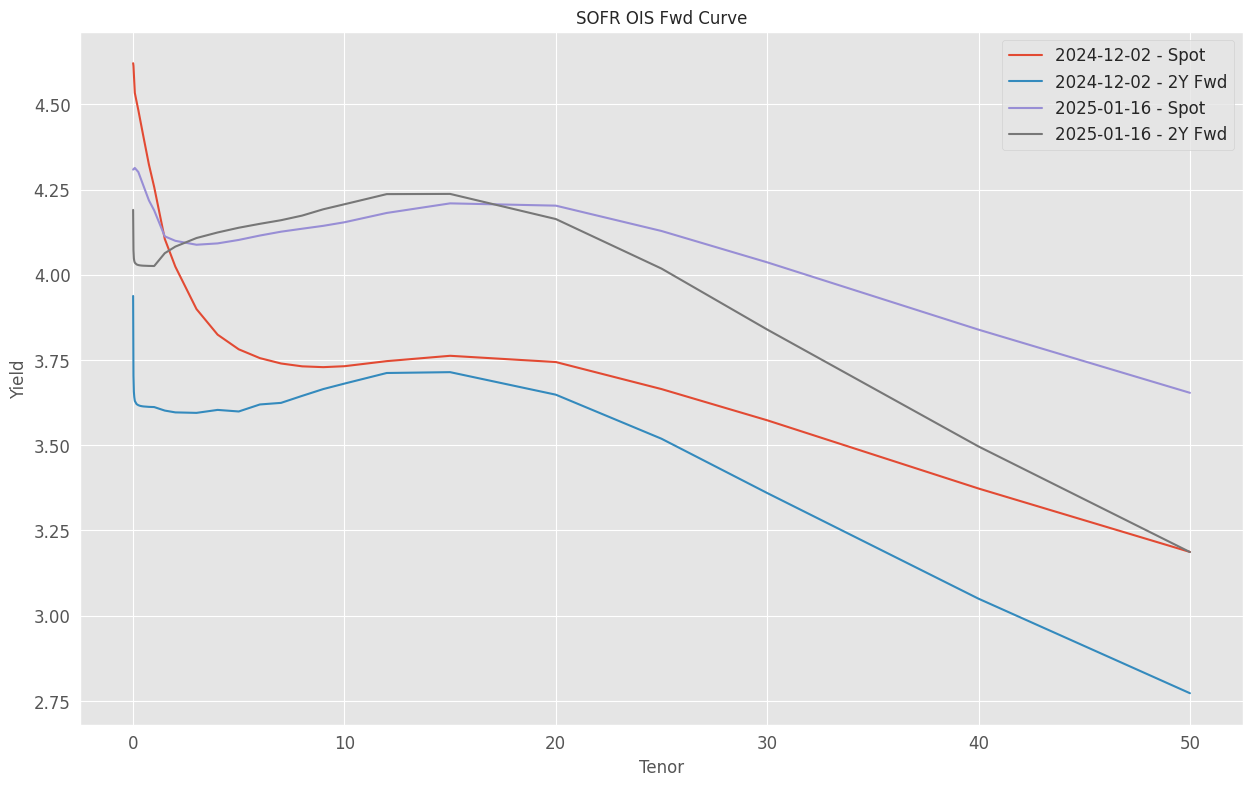

In [36]:
dt1 = datetime(2024, 12, 2)
dt2 = datetime(2025, 1, 16)

sofr_ois.fwd_grid_dict_curve_plotter(
    tenor_date_pairs=[("Spot", dt1), ("2Y Fwd", dt1), ("Spot", dt2), ("2Y Fwd", dt2)], fwd_grid_dict=fwd_grid_dict
)

- Spot Curve: ~100 bps of Fed rate cuts have brought the short end in respone but notice the parallel shift up by ~60 bps in the longer tenors as expections of a 2% core PCE waver
- 2Y Fwd Curve: Noticable parallel shift up from early 2024 when market expectations were a deep cutting cycle throughout 24 and into 25. Term premium has slowly been priced into the belly of the curve. Negative swap spreads and convexity effect evident into the longer end.

According to our screener, paying the belly in a 2Y Fwd 1s2s15s is the most attractive based on PCA residual z-scores. Note we're using basic fly weights right now: [1, 2, 1]. Let's see the timeseries:

In [11]:
short_wing = "2Y Fwd 12M"
belly = "2Y Fwd 2Y"
long_wing = "2Y Fwd 15Y"
wing_curve = "2Y Fwd 12M-2Y Fwd 15Y"
fly = "2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y"

PLOTTING SWAPS: 100%|██████████| 250/250 [00:00<00:00, 397.60it/s]


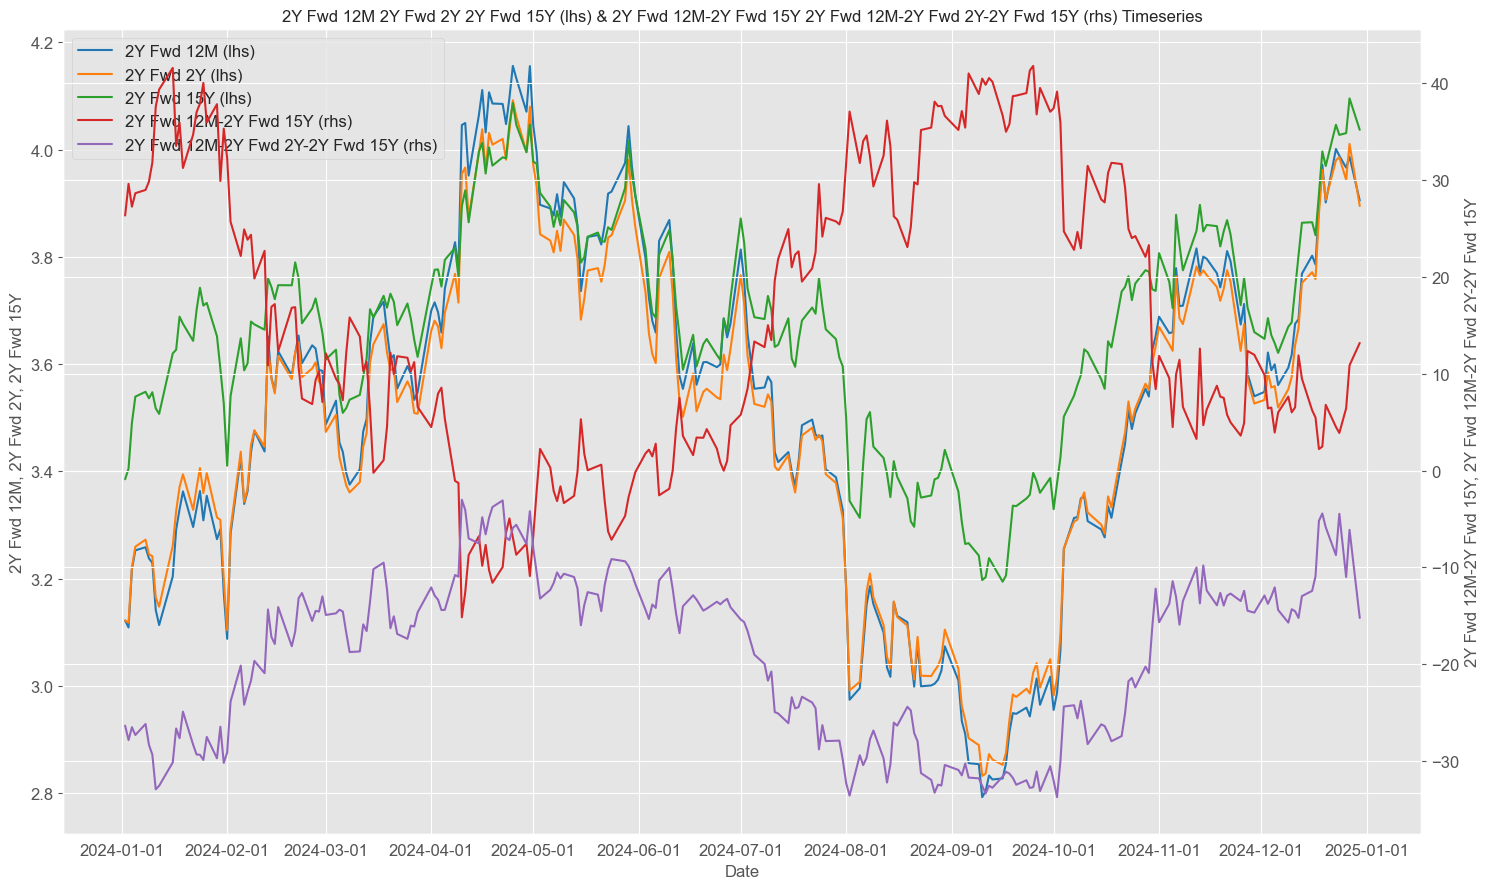

In [12]:
sofr_ois.fwd_grid_dict_timeseries_plotter(
    fwd_grid_dict=fwd_grid_dict, 
    tenors_to_plot=[short_wing, belly, long_wing],
    tenors_to_plot_on_secondary_axis=[wing_curve, fly],
    bdates=bdates, 
)

At a first glance, paying the belly in 2Y Fwd 1s2s15s doesn't look the most attractive but let's see if we can put some makeup on.

PLOTTING PCA RESIDUAL ZSCORES: 100%|██████████| 190/190 [00:00<00:00, 673.93it/s]


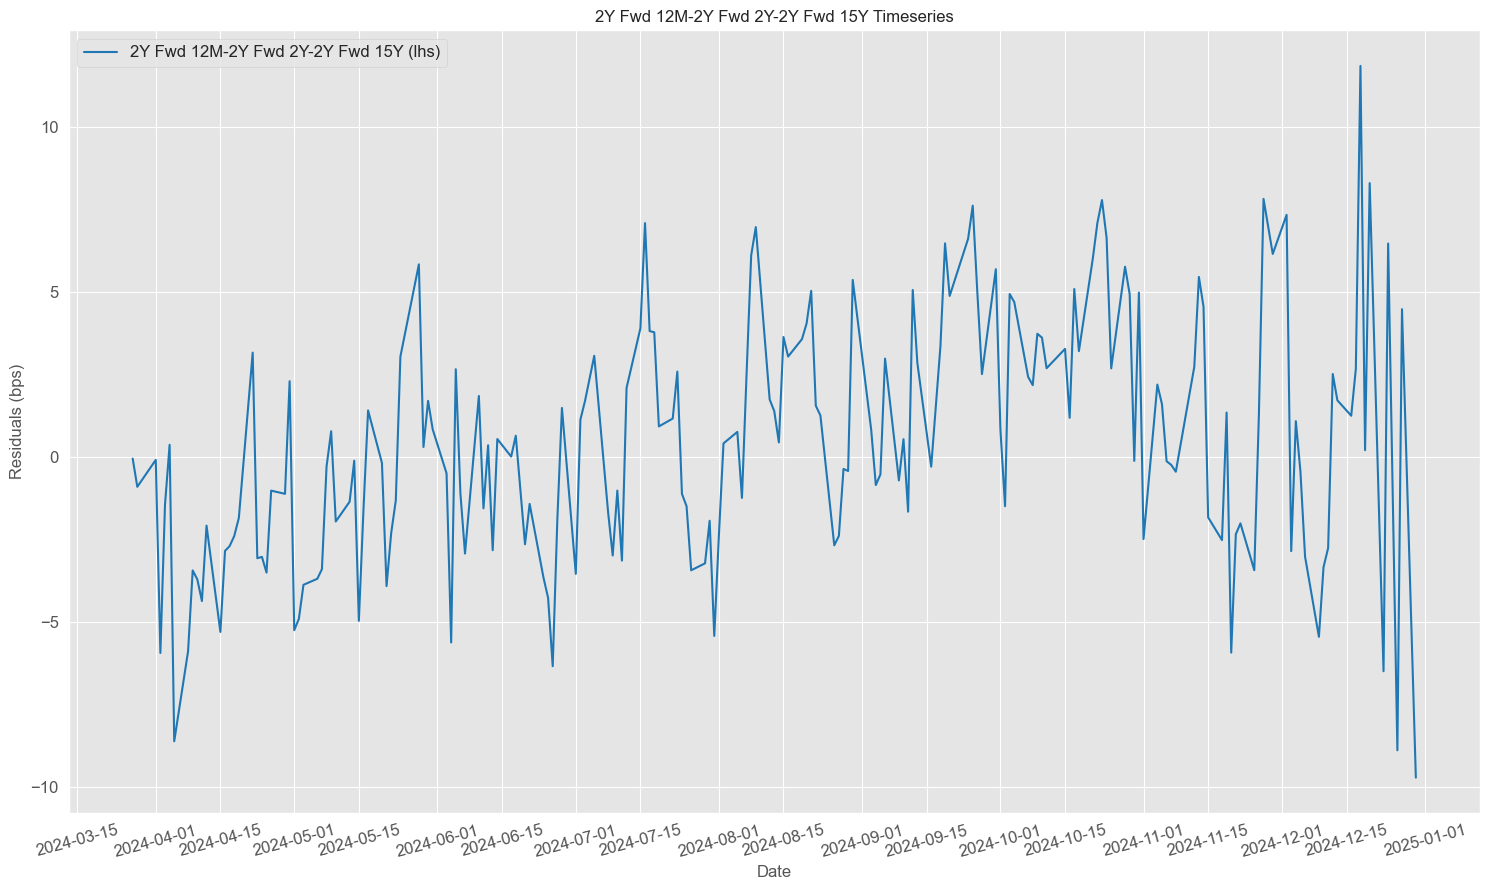

In [13]:
sofr_ois.pca_residual_timeseries_plotter(
    pca_results=pca_results, tenors_to_plot=[fly], key="rich_cheap_residual_zscore_timeseries_dict"
)

We can come up with "better" hedge ratios. We'll re-run PCA on a timeseries of ["2Y Fwd 12M", "2Y Fwd 2Y", "2Y Fwd 15Y"] and derive the weightings needed to elimate PC1 (level) exposure.

In [14]:
timeseries_df = sofr_ois.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=[short_wing, belly, long_wing, wing_curve, fly],
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 12, 30),
    tenor_is_df_index=True,
    scale_curve=True,
    scale_fly=True,
    custom_fly_weights=[1, 2, 1]
)
timeseries_df

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 250/250 [00:00<00:00, 396.14it/s]


,Date,2Y Fwd 12M,2Y Fwd 2Y,2Y Fwd 15Y,2Y Fwd 12M-2Y Fwd 15Y,2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y
0,2024-01-02,3.121935,3.122010,3.385416,26.348086,-26.333239
1,2024-01-03,3.109007,3.117982,3.405200,29.619298,-27.824366
2,2024-01-04,3.217962,3.221794,3.490572,27.260918,-26.494605
3,2024-01-05,3.252875,3.259628,3.539373,28.649824,-27.299176
4,2024-01-08,3.258582,3.272703,3.548440,28.985818,-26.161539
...,...,...,...,...,...,...
244,2024-12-23,4.001118,3.980116,4.046297,4.517977,-8.718257
245,2024-12-24,3.988454,3.985642,4.027382,3.892788,-4.455264
246,2024-12-26,3.966278,3.943562,4.030653,6.437510,-10.980786
247,2024-12-27,3.986716,4.010543,4.095496,10.878035,-6.112498


In [109]:
pca_hedge_results = calc_pca_loadings_matrix(
    df=timeseries_df[["Date", short_wing, belly, long_wing]].set_index("Date"), 
    # run_on_level_changes=True, 
    scale_loadings=True
)

loadings = pca_hedge_results["loading_matrix"].values

pc1_hedge_weights = np.array([-1 / loadings[0, 0], 2 / loadings[1, 0], -1 / loadings[2, 0]])
scaled_pc1_hedge_weights = [2 * pc1_hedge_weights[0] / pc1_hedge_weights[1], 2, 2 * pc1_hedge_weights[2] / pc1_hedge_weights[1]] 
print("PC1 Hedge Weights", scaled_pc1_hedge_weights)

pc1_pc2_hedge_weights = np.linalg.inv(
    np.array(
        [
            [loadings[0, 0], loadings[2, 0]],
            [loadings[0, 1], loadings[2, 1]],
        ]
    )
) @ np.array([loadings[1, 0], loadings[1, 1]])
scaled_pc1_pc2_hedge_weights = [-2 * pc1_pc2_hedge_weights[0], 2, -2 * pc1_pc2_hedge_weights[1]] 
print("PC1 & PC2 Hedge Weights", scaled_pc1_pc2_hedge_weights)


timeseries_df[f"{fly}_PC1_Hedged"] = (
    (scaled_pc1_hedge_weights[1] * timeseries_df[belly])
    + (scaled_pc1_hedge_weights[0] * timeseries_df[short_wing])
    + (scaled_pc1_hedge_weights[2] * timeseries_df[long_wing])
) * 100

timeseries_df[f"{fly}_PC1_PC2_Hedged"] = (
    (scaled_pc1_pc2_hedge_weights[1] * timeseries_df[belly])
    + (scaled_pc1_pc2_hedge_weights[0] * timeseries_df[short_wing])
    + (scaled_pc1_pc2_hedge_weights[2] * timeseries_df[long_wing])
) * 100

PC1 Hedge Weights [np.float64(-0.9153755972003511), 2, np.float64(-1.5392850157935565)]
PC1 & PC2 Hedge Weights [np.float64(-1.4699446805498348), 2, np.float64(-0.6067280601208683)]


Let's compare this with the 1-2-1 fly:

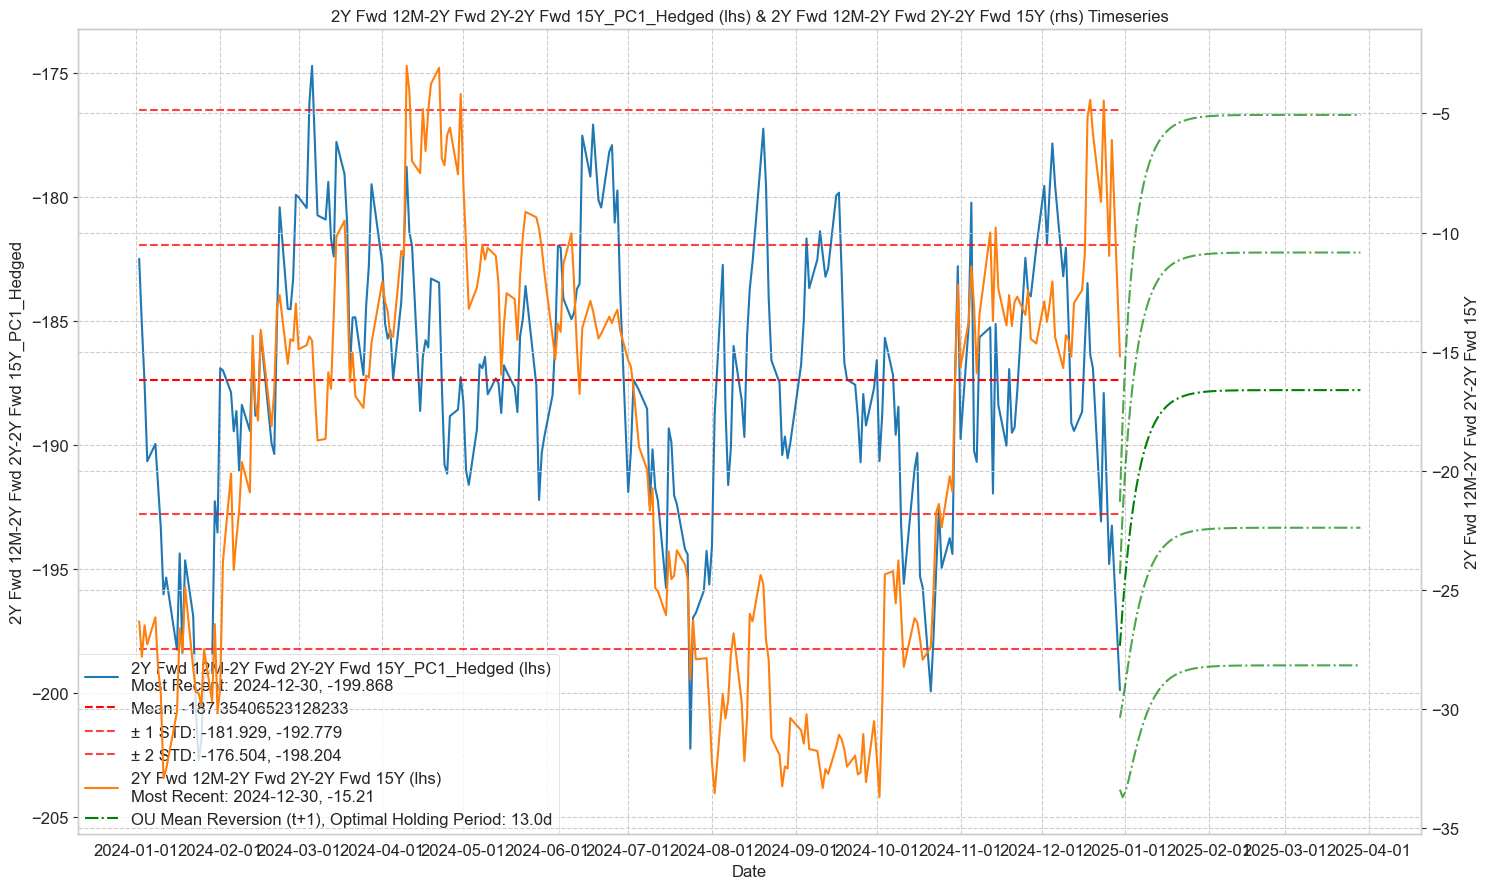

In [114]:
sofr_ois._general_df_plotter(
    df=timeseries_df,
    cols_to_plot=[f"{fly}_PC1_Hedged"],
    cols_to_plot_raxis=[fly],
    stds={f"{fly}_PC1_Hedged": [1, 2]},
    run_ou_mr_col_steps=(f"{fly}_PC1_Hedged", 90),
    show_2_sigma_ou_band=True,
    show_1_sigma_ou_band=True
)

The PCA weighted fly shows some nice mean reversion. At this level, it looks attractive to enter into a belly paying position.


Let's see if basic regression analysis backs up our PCA analysis.

- Regressing the fly on the belly gives a quick and dirty relative measure of historical convexity/concavity (not the bond one)
- We are essentially betting on the measure of convexity/concavity to mean revert
- A single variable regression ignores the variability of PC2 moves i.e. the slope of the wings
- To address this we also run regress the fly on the belly and curve

                                   OLS Regression Results                                  
Dep. Variable:     2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y   R-squared:                       0.872
Model:                                         OLS   Adj. R-squared:                  0.872
Method:                              Least Squares   F-statistic:                     1685.
Date:                             Tue, 31 Dec 2024   Prob (F-statistic):          2.56e-112
Time:                                     21:13:29   Log-Likelihood:                -629.48
No. Observations:                              249   AIC:                             1263.
Df Residuals:                                  247   BIC:                             1270.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

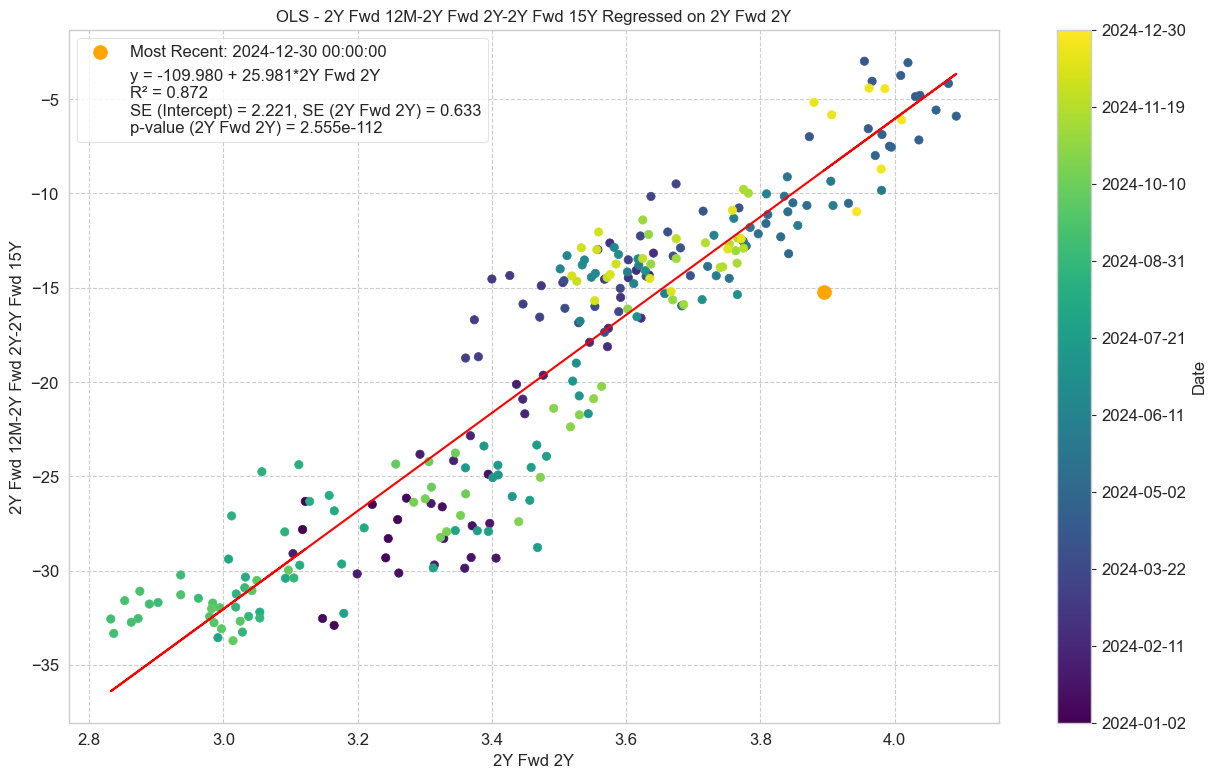

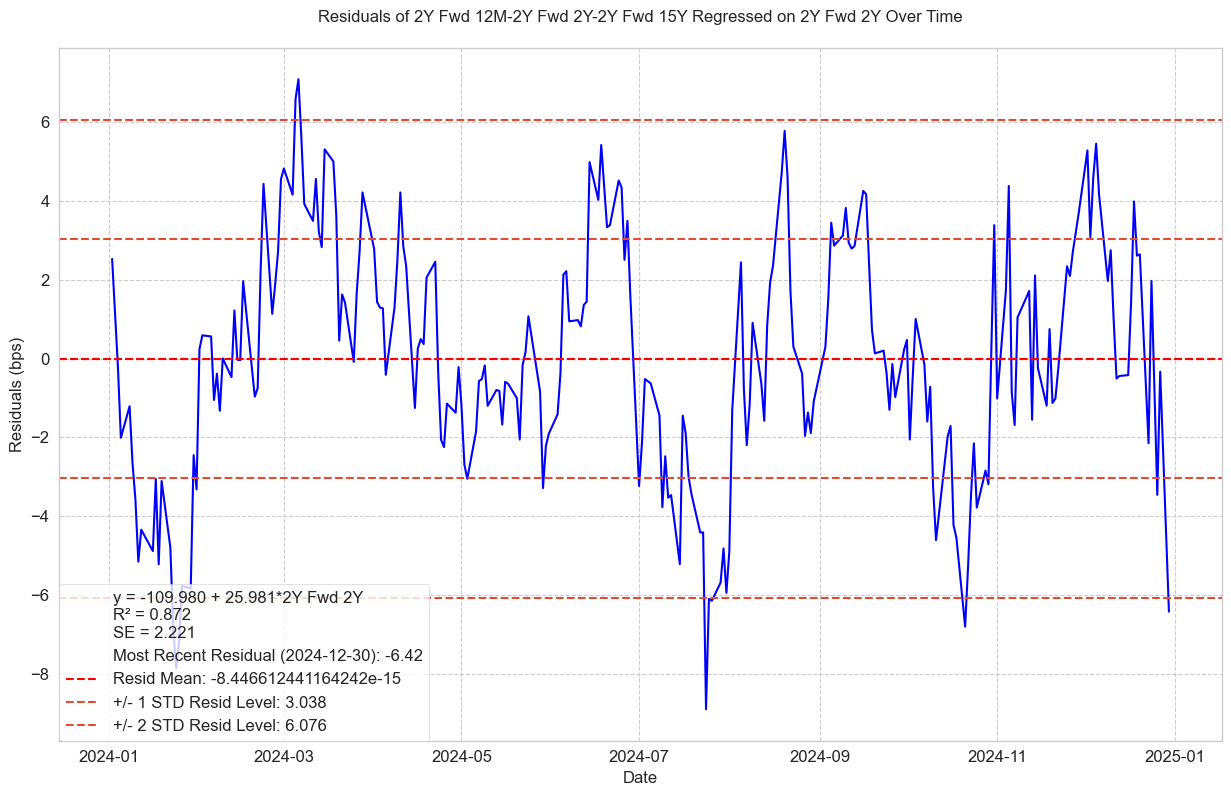

In [127]:
r = run_basic_linear_regression_df(
    df=timeseries_df,
    x_col=belly,
    y_col=fly,
    plot_most_recent=True,
    date_color_bar=True,
)
plot_residuals_timeseries(df=timeseries_df, results=r, stds=[1, 2])


The 1-2-1 weighted 1s2s15s has been well correlated to the directionality of the belly. Based off this historical relationship, we look a tad bit flat. The current residual is at -2 STDs, making a belly paying fly attractive even at the standard 1-2-1 weights.  

                                         OLS Regression Results                                         
Dep. Variable:     2Y Fwd 12M-2Y Fwd 2Y-2Y Fwd 15Y PCA Weighted   R-squared:                       0.000
Model:                                                      OLS   Adj. R-squared:                 -0.004
Method:                                           Least Squares   F-statistic:                   0.06772
Date:                                          Wed, 01 Jan 2025   Prob (F-statistic):              0.795
Time:                                                  09:43:14   Log-Likelihood:                -773.85
No. Observations:                                           249   AIC:                             1552.
Df Residuals:                                               247   BIC:                             1559.
Df Model:                                                     1                                         
Covariance Type:                                      n

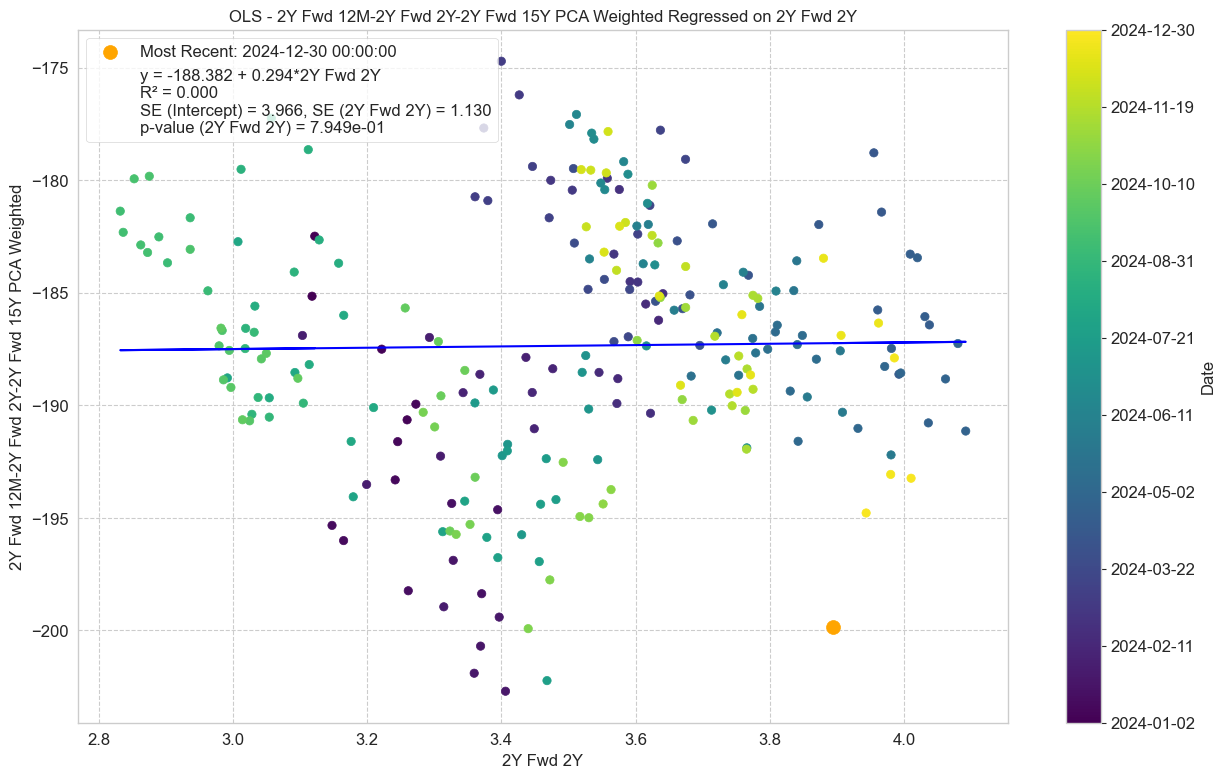

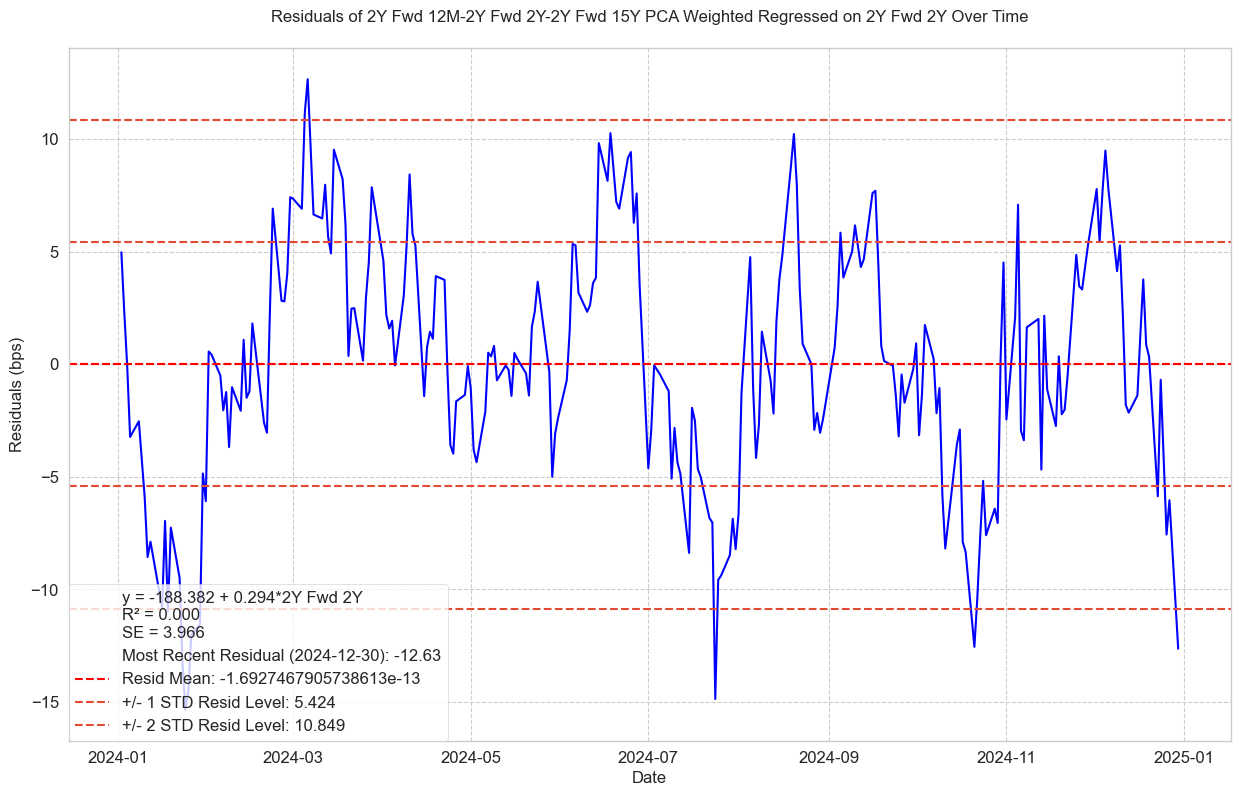

In [135]:
r = run_basic_linear_regression_df(
    df=timeseries_df,
    x_col=belly,
    y_col=f"{fly} PCA Weighted",
    plot_most_recent=True,
    date_color_bar=True,
)
plot_residuals_timeseries(df=timeseries_df, results=r, stds=[1, 2])

See above that regressing 2Y Fwd 1s2s15s PCA Weighted on 2Y Fwd 2Y gives us a position where we are hedge from the directionality of the belly. This is attractive if we want to bet on purely PC3 moves rather than have a source of lower dimenisonal PC moves in the variability of our positional PnL like we would have with a 1-2-1 fly weighting position. The

Simply regressing the fly on the belly won't allow us to truely see a view of relative value of the belly vs the wings. We must remove the effect of just the belly changing
or the slope of the wings changing. Once these effects are removed, the trade is driven purely by the relative performance of the belly or versus the short wing and long wing, rather than movements in direction or slope of the curve. We require a multiple regression where we regress 2Y Fwd 1s2s15s 1-2-1 Weighted on 2Y Fwd 2Y and 2Y Fwd 12M-2Y Fwd 15Y.

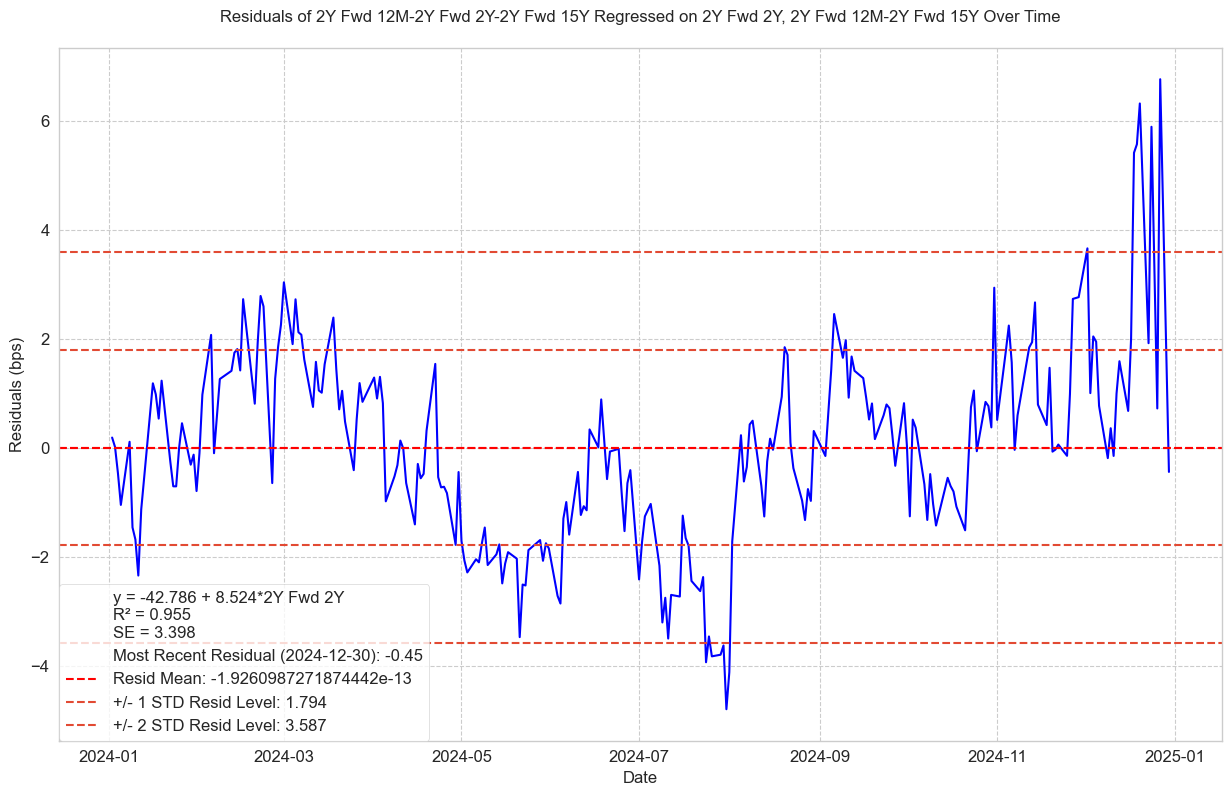

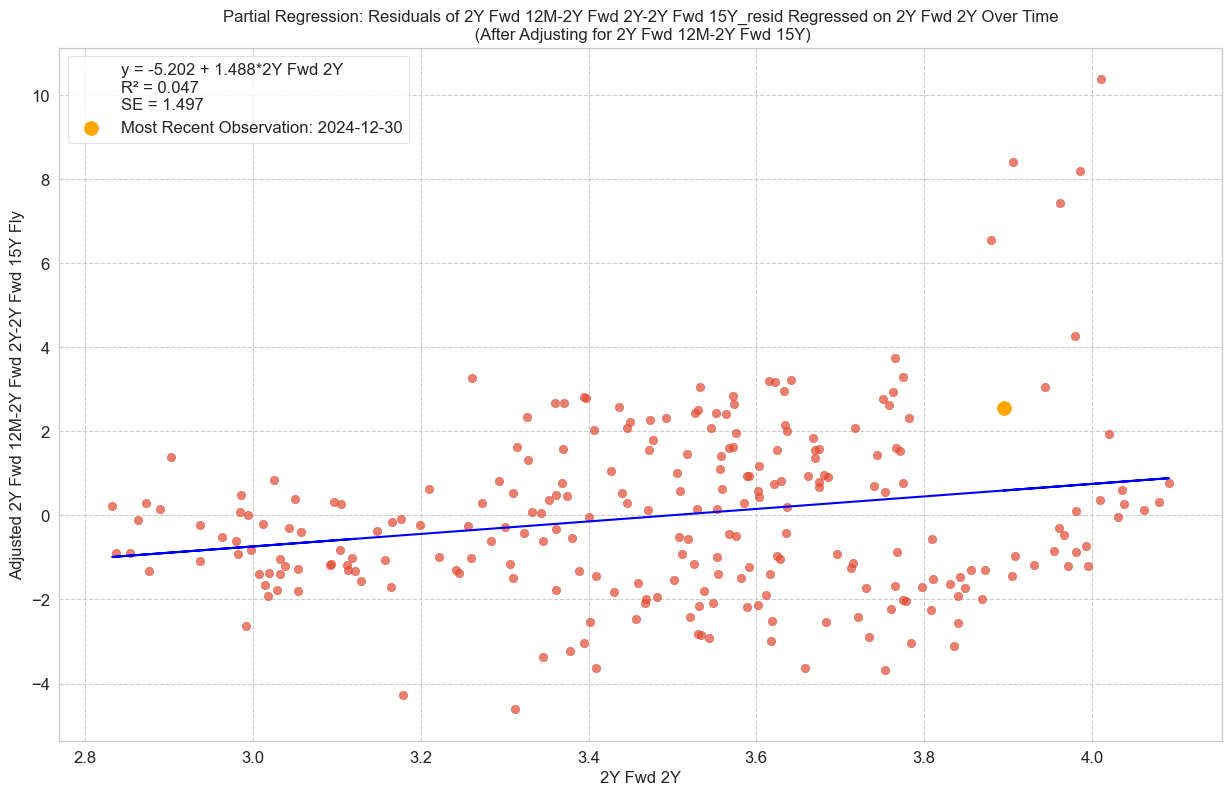

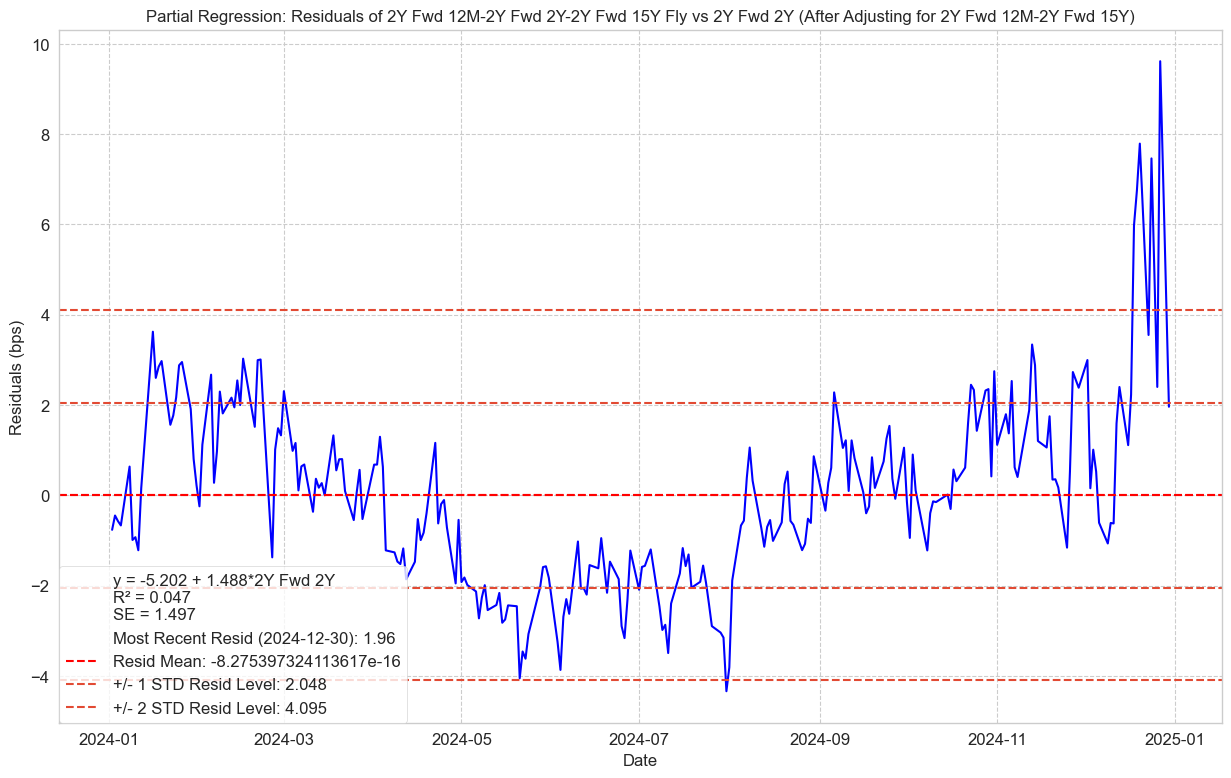

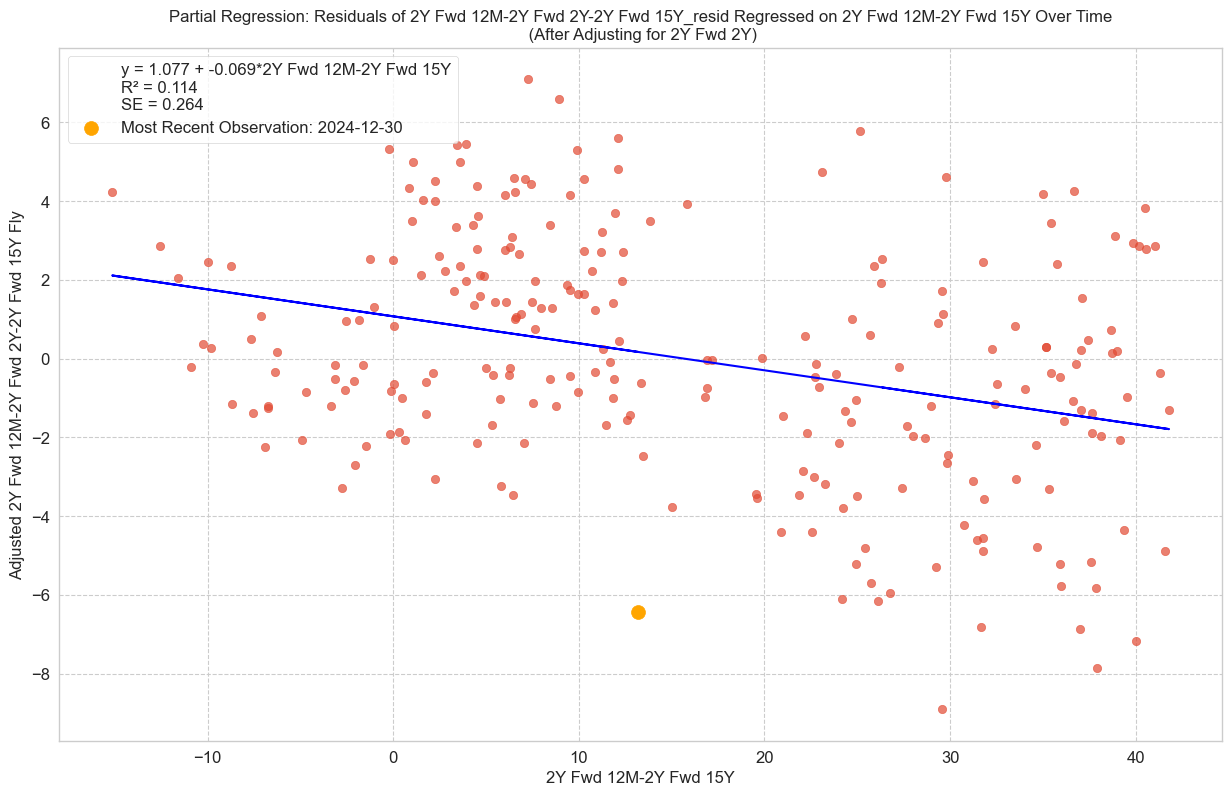

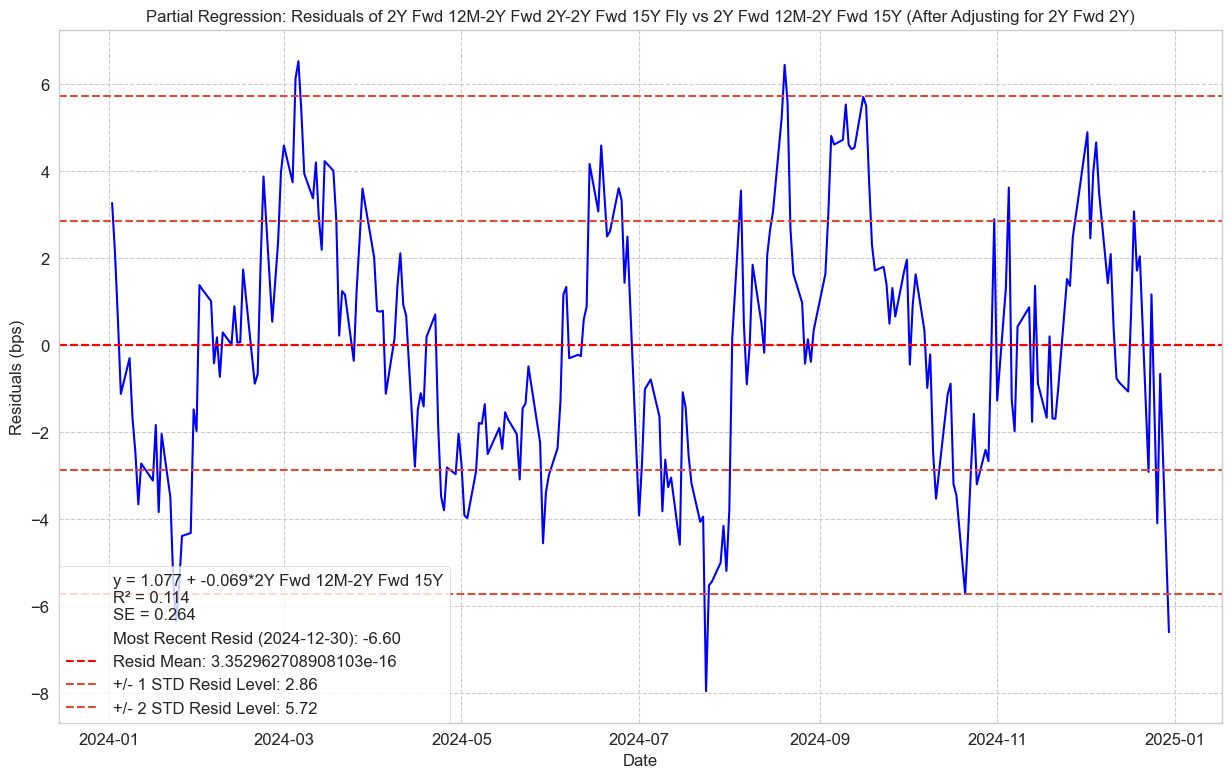

In [137]:
d, r = run_multiple_linear_regression_df(
    df=timeseries_df, x_cols=[belly, wing_curve], y_col=fly, show_plot=False
)
plot_residuals_timeseries(df=timeseries_df, results=r, stds=[1, 2])

modified_partial_regression_fly_plot(
    df=timeseries_df,
    x_cols=[belly, wing_curve],
    y_col=fly,
    show_residual_timeseries=True,
    show_regression=True,
    stds=[1, 2],
)
modified_partial_regression_fly_plot(
    df=timeseries_df,
    x_cols=[wing_curve, belly],
    y_col=fly,
    show_residual_timeseries=True,
    show_regression=True,
    stds=[1, 2],
)

See that the residuals of the 2Y Fwd 1s2s15s regressed on the 2Y Fwd 2Y and 2Y Fwd 1s15s suggest that we are trading at fair value given that level of 2Y Fwd 2Y AND 2Y Fwd 12M–2Y Fwd 15Y together. However, when conducting partial regressions, we see that conditional on (or “after adjusting for”) 2Y Fwd 2Y, the fly is notably cheap relative to 2Y Fwd 12M–2Y Fwd 15Y. In other words, if you hold the first factor neutral, the fly’s relationship to the second factor looks quite dislocated (cheap) or attractive to pay the belly. The question then is: Does this support hedging only the primary principal component (PC1) rather than hedging both PC1 and PC2?

2Y Fwd 2Y (often interpretable as a “near slope/level” factor) and 2Y Fwd 12M–2Y Fwd 15Y (often interpretable as a longer slope or slope/curve measure). 

Let's try to nail the point home: What the Partial Regression Is Telling You? Because the overall 2‐factor regression says the fly is “fair,” it implies: “Whatever cheapness we see vs. factor #2 is being offset by factor #1.” But if your goal is to exploit the cheapness vs. that second slope factor, you do not want to be fully hedged against both factors (since hedging out PC2 might also neutralize the cheapness you are trying to capture). Instead, you want to remove the exposure that is “overriding” that cheapness—in other words, remove the factor that’s offsetting it. Hence, if PC1 is effectively capturing a broad level or near-slope dynamic that “hides” the cheapness vs. the longer slope factor, then hedging out PC1 (and not also hedging PC2) can be the way to remain long (or short) that second-slope misalignment. If you hedge both PC1 and PC2, you might fully neutralize the fly’s exposure to both “level” and “slope,” leaving you with minimal or no “curvature” or “relative slope” exposure. That could flatten out the very cheapness you’re trying to capture. If you hedge only PC1, you remove the big parallel/level shift risk (the factor the multiple regression says is offsetting your “cheap” signal), but you stay exposed to factor #2 (the slope measure that shows the fly to be cheap on the partial regression). In short, you typically want to “hedge out” the factor(s) you don’t have a positive conviction on, while keeping exposure to the factor that is giving you your “edge.” The partial-regression cheapness (relative to the second factor) does suggest that it may make more sense to hedge only PC1 (the primary level or slope factor) rather than hedging both PC1 and PC2. By hedging both, you would likely neutralize the very mismatch you want to exploit. Instead, hedging only the first principal component keeps you long (or short) the specific slope factor that your partial regression shows is off‐market, allowing you to capture any mean‐reverting cheapness in the belly.

All of this ultimately points to a mispriced slope of the wings: 2Y Fwd 2Y-2Y Fwd 15Y in our case.

Something extra: Reproducing the residual bar plot in Credit Suisse's PCA Unleashed paper

In [407]:
sofr_ois.pca_residual_credit_suisse_BBar_plot(
    pca_results=pca_results,
    tenors_to_plot=[
        "2Y",
        "3Y",
        "4Y",
        "5Y",
        "6Y",
        "7Y",
        "8Y",
        "9Y",
        "10Y",
        "12Y",
        "15Y",
        "20Y",
        "25Y",
        "30Y",
        "40Y",
        "50Y",
        "12M Fwd 12M",
        "12M Fwd 2Y",
        "12M Fwd 3Y",
        "12M Fwd 4Y",
        "12M Fwd 5Y",
        "12M Fwd 6Y",
        "12M Fwd 7Y",
        "12M Fwd 8Y",
        "12M Fwd 9Y",
        "12M Fwd 10Y",
        "12M Fwd 12Y",
        "12M Fwd 15Y",
        "12M Fwd 20Y",
        "12M Fwd 25Y",
        "12M Fwd 30Y",
        "12M Fwd 40Y",
        "12M Fwd 50Y",
    ],
    bday_offsets=[20, 5], 
    title="2024-12-24 PCA Residuals from YTD Spot & 12M Fwd SOFR OIS Daily Rates with 1W & 1M Old Residuals Overlaid (skinner & lighter => older)"
)